# Analysing Different Methods of Finding $Q^2$ and $x$

## Finding $x$ and $Q^2$ using eletron scattering and the final hadronic state

In [2]:
import numpy as np
import uproot as ur
import awkward as ak
import matplotlib.pyplot as plt
# 18X275 or 5x41
E, Ep = 5, 41
s = 4 * E * Ep
xe, xjb, xdiff, epz = [], [], [], []


eAngle, eEnergy, epz, pth = [], [], [], []

Q2e, Q2jb = [],[]
fileCount = 5

# indexes of x we used
indexes = [[] for i in range(fileCount)]

# get data from file

files = list(f'../../data/pythia8NCDIS_{E}x{Ep}_minQ2=10_beamEffects_xAngle=-0.025_hiDiv_1.084{i}.eicrecon.tree.edm4eic.root' for i in range(fileCount))

for f, file_path in enumerate(files):
    events = ur.open(file_path + ':events')
    reconstructed_charged_particles = events['ReconstructedChargedParticles'].arrays()

    # loop through events to find electrons and store their momentum
    for i, event in  enumerate(reconstructed_charged_particles['ReconstructedChargedParticles.PDG']):
        eh, pzh, pyh, pxh, hadrons = 0, 0, 0, 0, 0
        
        xevent = []
        Q2event = []

        angleEvents = []
        energyEvents = []
        
        # if its just an electron, remove it
        if 1 == len(event):
            continue

        
        for j, particle in  enumerate(event):
            # if its an electron, find with scattered electron method
            if particle == 11:
                
                
                m = reconstructed_charged_particles['ReconstructedChargedParticles.mass'][i][j]
                kp1, kp2, kp3 = reconstructed_charged_particles['ReconstructedChargedParticles.momentum.x'][i][j], reconstructed_charged_particles['ReconstructedChargedParticles.momentum.y'][i][j], reconstructed_charged_particles['ReconstructedChargedParticles.momentum.z'][i][j]
                
                # check psuedo-rapidity
                kp = np.sqrt(kp1**2 + kp2**2 + kp3**2)
                theta = np.arccos(kp3/kp)
                pr = -np.log(np.tan(theta / 2))
                
                # remove particles with -4 < psuedo-rapidity < 4
                if abs(pr) < 4:

                    theta = np.arctan2(np.sqrt(kp1**2 + kp2**2), kp3)

                    k3 = -E
                    m0 = 0.000511
                    kp0 = np.sqrt(m0**2+(kp1**2+kp2**2+kp3**2))
                    k0 = np.sqrt(m0**2 + k3**2)
                    q0 = k0 - kp0
                    q1 =    - kp1
                    q2 =    - kp2
                    q3 = k3 - kp3
                    Q2 =-(q0**2 - q1**2 - q2**2 - q3**2) 
                    Q2event.append(Q2)


                    alpha = -0.025
                    p1 = Ep * np.sin(alpha)
                    p2 = 0
                    p3 = Ep * np.cos(alpha)
                    p0 = np.sqrt(0.938**2 + p1**2 + p2**2 + p3**2)
                    pq = p0 * q0 - p1 * q1 - p2 * q2 - p3 * q3
                    xevent.append(0.5 * Q2 / pq)
                    energyEvents.append(kp0)
                    angleEvents.append(theta)
                    
                    
                    
            # get the sum of components from hadrons for JB method
            elif abs(particle) == 211 or abs(particle) == 321 or particle == 2212:
                
                
                m = reconstructed_charged_particles['ReconstructedChargedParticles.mass'][i][j]
                kp1, kp2, kp3 = reconstructed_charged_particles['ReconstructedChargedParticles.momentum.x'][i][j], reconstructed_charged_particles['ReconstructedChargedParticles.momentum.y'][i][j], reconstructed_charged_particles['ReconstructedChargedParticles.momentum.z'][i][j]
                
                
                kp = np.sqrt(kp1**2 + kp2**2 + kp3**2)
                theta = np.arccos(kp3/kp)
                pr = -np.log(np.tan(theta / 2))
                
                if abs(pr) < 4:
                    hadrons += 1
                    eh  += np.sqrt(m**2+(kp1**2+kp2**2+kp3**2))
                    pxh += kp1
                    pyh += kp2
                    pzh += kp3
                
        
        # add one per event
        y = 1/(2 * E) * (eh - pzh)
        Q2 = 1/(1 - y) * (pxh**2 + pyh**2)
        
        if hadrons != 0 and len(Q2event) != 0:
            indexes[f].append(i)
            epz.append((eh - pzh))
            pth.append((pxh**2 + pyh**2))
            eAngle.append(angleEvents[Q2event.index(max(Q2event))])
            eEnergy.append(energyEvents[Q2event.index(max(Q2event))])


            xjb.append(Q2 / (s * y))
            xe.append(xevent[Q2event.index(max(Q2event))])

            Q2jb.append(Q2)
            Q2e.append(max(Q2event))



## Finding the true $x$ and $Q^2$

In [3]:
mc_particles = events['MCParticles'].arrays()

Q2true, xtrue, ytrue = [], [], []
# loop through all the indexes we got the other values from so we skip the same events
for lst  in indexes:
    for i in lst:
        event = mc_particles['MCParticles.PDG'][i]
        Q2tot, xtot, ytot = [], [], []
        for j, particle in enumerate(event):
            if mc_particles['MCParticles.generatorStatus'][i][j] != 1 or particle != 11:
                continue
            
            psx, psy, psz = mc_particles['MCParticles.momentum.x'][i][j], mc_particles['MCParticles.momentum.y'][i][j], mc_particles['MCParticles.momentum.z'][i][j]
            Eproton = np.sqrt(0.000511**2 + psx**2 + psy**2 + psz**2)
            theta = np.arctan2(np.sqrt(psx**2 + psy**2), psz)
            
            Q2 = 2 * E * Eproton * (1 + np.cos(theta))
            
            y = 1 - 0.5 * Eproton / E * (1 - np.cos(theta))
            x = Q2 / s / y
            xtot.append(x)
            Q2tot.append(Q2)
            ytot.append(x)

        # if we have multiple events, use one with largest Q2
        if len(xtot) > 0:
            xtrue.append(xtot[Q2tot.index(max(Q2tot))])
            ytrue.append(ytot[Q2tot.index(max(Q2tot))])
            Q2true.append(max(Q2tot))

print(len(xtrue))

5085


In [82]:
import math

for i in range(len(xtrue)):
    q2 = 2 * eEnergy[i] * E * (1 + math.cos(eAngle[i]))
    y = (1/2/E) * epz[i]
    q3 = 1/(1 - y) * pth[i]


## Training Artificial Neural Network

In [6]:
import torch
import torch.nn.functional as F 
import torch.nn as nn



# Define neural network 
class Network(nn.Module): 
   def __init__(self, input_size, output_size): 
       super(Network, self).__init__() 
        
       self.layer1 = nn.Linear(input_size, 5) 
       self.layer2 = nn.Linear(5, 5) 
       self.layer3 = nn.Linear(5, 5) 
       self.layer4 = nn.Linear(5, output_size) 


   def forward(self, x): 
       x1 = F.relu(self.layer1(x)) 
       x2 = F.relu(self.layer2(x1)) 
       x3 = F.relu(self.layer3(x2)) 
       x4 = self.layer4(x3) 
       return x4

  # Train the model
def train(model, indexes, loss_fn, optimizer, num_epochs):
    for epoch in range(num_epochs):
      print(epoch)
      for i in indexes:
        input_sequence = torch.Tensor([eAngle[i], pth[i], eEnergy[i], epz[i]])
        input_sequence = input_sequence.unsqueeze(0)

        target = torch.Tensor([Q2true[i]])
      
        # Forward pass
        output = model(input_sequence)
        loss = loss_fn(output, target)
      
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


  # Test the model
def test(model, indexes, loss_fn):
    accuracy = 0
    total_loss = 0
    for i in indexes:
        input_sequence = torch.Tensor([eAngle[i], pth[i], eEnergy[i], epz[i]])
        input_sequence = input_sequence.unsqueeze(0)
        target = torch.Tensor([Q2true[i]])
        
        output = model(input_sequence)
        total_loss += loss_fn(output, target).item()

        print(target, output)
        accuracy += (target - output) / target
    return accuracy / len(indexes)

# Setup the model, data, loss function and optimizer
model = Network(4, 1)
data = [(list(range(10)), list(range(1, 11))), (list(range(10, 20)), list(range(11, 21)))]
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())


trainingData = int(len(xtrue) * 3/4)
testingData = len(xtrue) - trainingData

# Train the model
train(model,  list(range(trainingData)), loss_fn, optimizer, num_epochs=10)
print(test(model, list(range(trainingData, len(xtrue))), loss_fn))


0


c:\Users\eholt\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1
2
3
4
5
6
7
8
9
tensor([10.0947]) tensor([[23.3164]], grad_fn=<AddmmBackward0>)
tensor([12.3840]) tensor([[23.5307]], grad_fn=<AddmmBackward0>)
tensor([13.8451]) tensor([[23.4383]], grad_fn=<AddmmBackward0>)
tensor([15.7927]) tensor([[22.7376]], grad_fn=<AddmmBackward0>)
tensor([18.1254]) tensor([[23.1970]], grad_fn=<AddmmBackward0>)
tensor([16.3314]) tensor([[22.2661]], grad_fn=<AddmmBackward0>)
tensor([25.2297]) tensor([[21.9082]], grad_fn=<AddmmBackward0>)
tensor([16.2508]) tensor([[23.6118]], grad_fn=<AddmmBackward0>)
tensor([12.7122]) tensor([[22.1415]], grad_fn=<AddmmBackward0>)
tensor([16.4243]) tensor([[24.3780]], grad_fn=<AddmmBackward0>)
tensor([13.3810]) tensor([[14.5861]], grad_fn=<AddmmBackward0>)
tensor([11.2181]) tensor([[23.1260]], grad_fn=<AddmmBackward0>)
tensor([20.4041]) tensor([[23.1134]], grad_fn=<AddmmBackward0>)
tensor([43.7662]) tensor([[23.5050]], grad_fn=<AddmmBackward0>)
tensor([26.7174]) tensor([[23.7078]], grad_fn=<AddmmBackward0>)
tensor([11.5690]) tens

In [ ]:
x_bins = np.logspace(-4, 0, 30) # specify exponents of 10
Q2_bins = np.logspace(0, 3, 40) # specify exponents of 10

print(aiTrue)

plt.hist2d(aiOP, aiTrue, bins = [Q2_bins, Q2_bins],cmin = 1)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$x_{ai}$')
plt.ylabel('$x_{true}$')

In [67]:
# Import the libraries required in this example:
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.layers import Input, Concatenate, Dense
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential


in_tensor_1 = Input(shape=(1,), name = "energy")
in_tensor_2 = Input(shape=(1,), name = "angle")
in_tensor_3 = Input(shape=(1,), name = "pth")
in_tensor_4 = Input(shape=(1,), name = "epz")


out_tensor = Concatenate()([in_tensor_1, in_tensor_2, in_tensor_3, in_tensor_4])
output_tesor = Dense(1)(out_tensor)

model = Model(inputs = [in_tensor_1, in_tensor_2, in_tensor_3, in_tensor_4],outputs = out_tensor)

model.compile(
    optimizer=keras.optimizers.RMSprop(),  # Optimizer
    # Loss function to minimize
    loss=keras.losses.SparseCategoricalCrossentropy(),
    # List of metrics to monitor
    metrics=[keras.metrics.MeanSquaredError()],
)





trainingData = int(len(xtrue) * 1/2)
validationData = int(len(xtrue) * 3/4) - int(len(xtrue) * 1/2)
testingData = len(xtrue) - trainingData - validationData


x_train = [eAngle[:trainingData], 
            pth[:trainingData],
            eEnergy[:trainingData],
            epz[:trainingData]]

x_train = []

for i in range(trainingData):
    x_train.append([eAngle[i], 
            pth[i],
            eEnergy[i],
            epz[i]])



print(x_train)
y_train = Q2true[:trainingData]

x_val = [eAngle[trainingData:validationData], 
            pth[trainingData:validationData],
            eEnergy[trainingData:validationData],
            epz[trainingData:validationData]]

y_val = [Q2true[trainingData:validationData]]


train = tf.data.Dataset.from_tensor_slices([eAngle[:trainingData], 
            pth[:trainingData],
            eEnergy[:trainingData],
            epz[:trainingData],
            Q2true[:trainingData]])

'''history = model.fit(
    x_train,
    y_train,
    batch_size=64,
    epochs=2,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(x_val, y_val),
)'''

def _input_fn():
  sent1 = np.array(pth[:trainingData], dtype=np.float64)
  sent2 = np.array(epz[:trainingData], dtype=np.float64)
  sent3 = np.array(eAngle[:trainingData], dtype=np.float64)
  sent4 = np.array(eEnergy[:trainingData], dtype=np.float64)

  sent1 = np.reshape(sent1, (trainingData, 1, 1))
  sent2 = np.reshape(sent2, (trainingData, 1, 1))
  sent3 = np.reshape(sent3, (trainingData, 1, 1))
  sent4 = np.reshape(sent4, (trainingData, 1, 1))

  labels = np.array(Q2true[:trainingData], dtype=np.float64)
  labels = np.reshape(labels, (trainingData, 1))

  def generator():
    for s1, s2,s3,s4, l in zip(sent1, sent2,sent3,sent4, labels):
      yield {"pth": s1, "epz": s2, "angle" : s3, "energy":s4}, l

  dataset = tf.data.Dataset.from_generator(generator, output_types=({"pth": tf.float64, "epz": tf.float64, "angle" : tf.float64, "energy" : tf.float64}, tf.float64))
  dataset = dataset.batch(2)
  return dataset

...

model.fit(_input_fn(), epochs=10, steps_per_epoch=4)


[[2.2200517800608024, 11.280381923139885, 5.0110724431117974, 1.6553263574870307], [2.1868641402254365, 6.941230995887283, 5.834944054285169, 0.3832268084497841], [2.4616522825538962, 17.88851370375313, 5.372665780802342, 0.5387939792234988], [2.0993342338469327, 0.11054218716728743, 2.591795341963726, 3.0578587734400227], [1.798293353202432, 9.37096350086915, 3.995670285872212, 3.198996581264076], [2.0601675408119333, 7.150812645415665, 5.4464894069385545, 1.0356625823714118], [1.3963588473467408, 0.2401395868364391, 1.517821470338831, 8.21269333590393], [1.403815858049819, 19.431308569104008, 3.5816674550807543, 5.236309318972586], [2.3567249850154397, 1.8597237601607266, 4.764799800604538, 0.23946364858692704], [2.3782289036886057, 13.507795633066905, 5.3223923920342475, 1.1657340625419188], [2.497393825703936, 1.3346429672780011, 5.367663315179262, 0.12542083641945467], [2.408011938856981, 11.978065738601417, 5.572270488570666, 0.41652013731647486], [2.0665798154578527, 26.18968762

InvalidArgumentError: Graph execution error:

Detected at node SquaredDifference defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "c:\Users\eholt\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "c:\Users\eholt\AppData\Local\Programs\Python\Python311\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance

  File "c:\Users\eholt\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel\kernelapp.py", line 739, in start

  File "c:\Users\eholt\AppData\Local\Programs\Python\Python311\Lib\site-packages\tornado\platform\asyncio.py", line 205, in start

  File "c:\Users\eholt\AppData\Local\Programs\Python\Python311\Lib\asyncio\base_events.py", line 607, in run_forever

  File "c:\Users\eholt\AppData\Local\Programs\Python\Python311\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "c:\Users\eholt\AppData\Local\Programs\Python\Python311\Lib\asyncio\events.py", line 80, in _run

  File "c:\Users\eholt\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel\kernelbase.py", line 542, in dispatch_queue

  File "c:\Users\eholt\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel\kernelbase.py", line 531, in process_one

  File "c:\Users\eholt\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell

  File "c:\Users\eholt\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel\ipkernel.py", line 359, in execute_request

  File "c:\Users\eholt\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel\kernelbase.py", line 775, in execute_request

  File "c:\Users\eholt\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel\ipkernel.py", line 446, in do_execute

  File "c:\Users\eholt\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell

  File "c:\Users\eholt\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\interactiveshell.py", line 3051, in run_cell

  File "c:\Users\eholt\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\interactiveshell.py", line 3106, in _run_cell

  File "c:\Users\eholt\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner

  File "c:\Users\eholt\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\interactiveshell.py", line 3311, in run_cell_async

  File "c:\Users\eholt\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\interactiveshell.py", line 3493, in run_ast_nodes

  File "c:\Users\eholt\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\interactiveshell.py", line 3553, in run_code

  File "C:\Users\eholt\AppData\Local\Temp\ipykernel_16528\1530592414.py", line 101, in <module>

  File "c:\Users\eholt\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "c:\Users\eholt\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 1807, in fit

  File "c:\Users\eholt\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function

  File "c:\Users\eholt\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function

  File "c:\Users\eholt\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step

  File "c:\Users\eholt\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 1155, in train_step

  File "c:\Users\eholt\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 1249, in compute_metrics

  File "c:\Users\eholt\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\compile_utils.py", line 620, in update_state

  File "c:\Users\eholt\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\utils\metrics_utils.py", line 77, in decorated

  File "c:\Users\eholt\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\metrics\base_metric.py", line 140, in update_state_fn

  File "c:\Users\eholt\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\metrics\base_metric.py", line 723, in update_state

  File "c:\Users\eholt\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\losses.py", line 1706, in mean_squared_error

Incompatible shapes: [2] vs. [8]
	 [[{{node SquaredDifference}}]] [Op:__inference_train_function_14877]

In [10]:
import neurolab as nl

# Create the input and target data
x_train = []
y_train = []

x_test = []
y_test = []


trainingData = int(len(Q2true) * 3/4)
testingData = len(Q2true) - trainingData

for i in range(trainingData):
    x_train.append([eAngle[i].item(), 
            eEnergy[i].item(),
            pth[i].item(),
            epz[i].item()])

    y_train.append([xtrue[i]])

for i in range(trainingData, len(Q2true)):
    x_test.append([eAngle[i].item(), 
            eEnergy[i].item(),
            pth[i].item(),
            epz[i].item()])

    y_test.append([xtrue[i]])

minmax = [[min(eAngle), max(eAngle)], [min(eEnergy), max(eEnergy)], [min(pth), max(pth)], [min(epz), max(epz)]]

# Create the neural network
net = nl.net.newff(minmax, [24, 24, 1])
net.init()

# Train the neural network

print("Training...")
net.train(x_train, y_train, epochs=20, show = 1, goal = 0.02)

# Test the neural network
print("Testing...")
output = net.sim(x_test)

# Print the output

aiTrueX = []
aiOPX = []

for i in range(len(output)):
    aiOPX.append(output[i][0])
    aiTrueX.append(y_train[i][0])

    

Training...
Epoch: 1; Error: 845.2173887323328;
Epoch: 2; Error: 79.59718227122781;
Epoch: 3; Error: 66.9533166483676;
Epoch: 4; Error: 61.40617347282277;
Epoch: 5; Error: 52.362836458258556;
Epoch: 6; Error: 41.22495897181592;
Epoch: 7; Error: 40.121240098408066;
Epoch: 8; Error: 39.77900301084776;
Epoch: 9; Error: 39.23214219262778;
Epoch: 10; Error: 38.762746857656424;
Epoch: 11; Error: 38.643579126150094;
Epoch: 12; Error: 37.93373880940299;
Epoch: 13; Error: 37.55285236013894;
Epoch: 14; Error: 37.418341770094315;
Epoch: 15; Error: 37.25942617789633;
Epoch: 16; Error: 37.02466114540638;
Epoch: 17; Error: 36.92471869017514;
Epoch: 18; Error: 36.814895199545;
Epoch: 19; Error: 36.77848492410129;
Epoch: 20; Error: 36.74108729140732;
The maximum number of train epochs is reached
Testing...


In [11]:
import neurolab as nl

# Create the input and target data
x_train = []
y_train = []

x_test = []
y_test = []


trainingData = int(len(Q2true) * 3/4)
testingData = len(Q2true) - trainingData

for i in range(trainingData):
    x_train.append([eAngle[i].item(), 
            eEnergy[i].item(),
            pth[i].item(),
            epz[i].item()])

    y_train.append([ytrue[i]])

for i in range(trainingData, len(Q2true)):
    x_test.append([eAngle[i].item(), 
            eEnergy[i].item(),
            pth[i].item(),
            epz[i].item()])

    y_test.append([ytrue[i]])

minmax = [[min(eAngle), max(eAngle)], [min(eEnergy), max(eEnergy)], [min(pth), max(pth)], [min(epz), max(epz)]]

# Create the neural network
net = nl.net.newff(minmax, [24, 24, 1])
net.init()

# Train the neural network

print("Training...")
net.train(x_train, y_train, epochs=20, show = 1, goal = 0.02)

# Test the neural network
print("Testing...")
output = net.sim(x_test)

# Print the output

aiTrueY = []
aiOPY = []

for i in range(len(output)):
    aiOPY.append(output[i][0])
    aiTrueY.append(y_train[i][0])

Training...
Epoch: 1; Error: 98.5379604836049;
Epoch: 2; Error: 73.21939594143237;
Epoch: 3; Error: 63.90767222804121;
Epoch: 4; Error: 52.81563002190954;
Epoch: 5; Error: 46.372142294094445;
Epoch: 6; Error: 44.566091770355165;
Epoch: 7; Error: 41.77962925263704;
Epoch: 8; Error: 40.23152601233488;
Epoch: 9; Error: 39.7269892840157;
Epoch: 10; Error: 39.0362940238584;
Epoch: 11; Error: 38.34442544326139;
Epoch: 12; Error: 37.58782836323907;
Epoch: 13; Error: 37.40842370969278;
Epoch: 14; Error: 37.2959774815333;
Epoch: 15; Error: 37.23257767636963;
Epoch: 16; Error: 37.13838767394206;
Epoch: 17; Error: 37.00190206041207;
Epoch: 18; Error: 36.97980923869285;
Epoch: 19; Error: 36.94854682432183;
Epoch: 20; Error: 36.896194852204204;
The maximum number of train epochs is reached
Testing...


[0.11601853738842142, 0.14154627997834757, 0.1563986232101924, 0.060315212217201444, 0.02323546513836602, 0.08852086152983688, 0.28390056894801513, 0.3228755127025625, 0.08008302259903752, 0.17018440365738233, 0.08376428136616478, 0.434336598829886, 0.2701551229203894, 0.24663245188381824, 0.036117363736257714, 0.3558769510279034, 0.06524557826256043, 0.05400386655110162, 0.07707940094755157, 0.12182389749823276, 0.2271251827009169, 0.2797045522312499, 0.13058098925886627, 0.1204009146616264, 0.26525290120431183, 0.052024698877038936, 0.04030909211664014, 0.03809165920616956, 0.256880679056925, 0.04483671425365297, 0.02537476039135666, 0.02444170431022351, 0.1120684328681814, 0.13665974776618856, 0.10830840734432909, 0.08416359901172381, 0.032205782061794766, 0.030142507137653204, 0.17248287019681646, 0.05783330233670471, 0.15607911580351094, 0.15141611570850097, 0.0666296949907406, 0.12999339537825003, 0.06506905154569882, 0.21598076739783112, 0.17949340945125547, 0.04541814986243767,

Text(0, 0.5, '$x_{true}$')

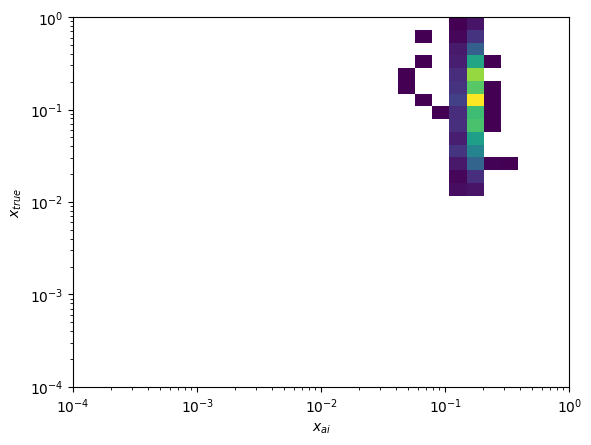

In [12]:
x_bins = np.logspace(-4, 0, 30) # specify exponents of 10
Q2_bins = np.logspace(0, 3, 40) # specify exponents of 10

print(aiTrueX)

plt.hist2d(aiOPX, aiTrueX, bins = [x_bins, x_bins],cmin = 1)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$x_{ai}$')
plt.ylabel('$x_{true}$')

[0.11601853738842142, 0.14154627997834757, 0.1563986232101924, 0.060315212217201444, 0.02323546513836602, 0.08852086152983688, 0.28390056894801513, 0.3228755127025625, 0.08008302259903752, 0.17018440365738233, 0.08376428136616478, 0.434336598829886, 0.2701551229203894, 0.24663245188381824, 0.036117363736257714, 0.3558769510279034, 0.06524557826256043, 0.05400386655110162, 0.07707940094755157, 0.12182389749823276, 0.2271251827009169, 0.2797045522312499, 0.13058098925886627, 0.1204009146616264, 0.26525290120431183, 0.052024698877038936, 0.04030909211664014, 0.03809165920616956, 0.256880679056925, 0.04483671425365297, 0.02537476039135666, 0.02444170431022351, 0.1120684328681814, 0.13665974776618856, 0.10830840734432909, 0.08416359901172381, 0.032205782061794766, 0.030142507137653204, 0.17248287019681646, 0.05783330233670471, 0.15607911580351094, 0.15141611570850097, 0.0666296949907406, 0.12999339537825003, 0.06506905154569882, 0.21598076739783112, 0.17949340945125547, 0.04541814986243767,

Text(0, 0.5, '$y_{true}$')

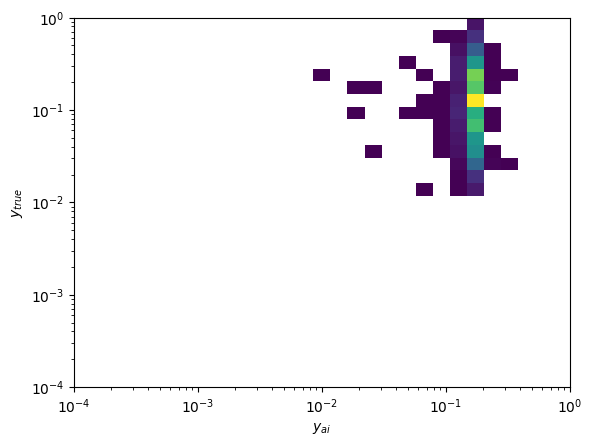

In [14]:
x_bins = np.logspace(-4, 0, 30) # specify exponents of 10
Q2_bins = np.logspace(0, 3, 40) # specify exponents of 10

print(aiTrueY)

plt.hist2d(aiOPY, aiTrueY, bins = [x_bins, x_bins],cmin = 1)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$y_{ai}$')
plt.ylabel('$y_{true}$')

[0.11601853738842142, 0.14154627997834757, 0.1563986232101924, 0.060315212217201444, 0.02323546513836602, 0.08852086152983688, 0.28390056894801513, 0.3228755127025625, 0.08008302259903752, 0.17018440365738233, 0.08376428136616478, 0.434336598829886, 0.2701551229203894, 0.24663245188381824, 0.036117363736257714, 0.3558769510279034, 0.06524557826256043, 0.05400386655110162, 0.07707940094755157, 0.12182389749823276, 0.2271251827009169, 0.2797045522312499, 0.13058098925886627, 0.1204009146616264, 0.26525290120431183, 0.052024698877038936, 0.04030909211664014, 0.03809165920616956, 0.256880679056925, 0.04483671425365297, 0.02537476039135666, 0.02444170431022351, 0.1120684328681814, 0.13665974776618856, 0.10830840734432909, 0.08416359901172381, 0.032205782061794766, 0.030142507137653204, 0.17248287019681646, 0.05783330233670471, 0.15607911580351094, 0.15141611570850097, 0.0666296949907406, 0.12999339537825003, 0.06506905154569882, 0.21598076739783112, 0.17949340945125547, 0.04541814986243767,

Text(0, 0.5, '$Q^2_{true}$')

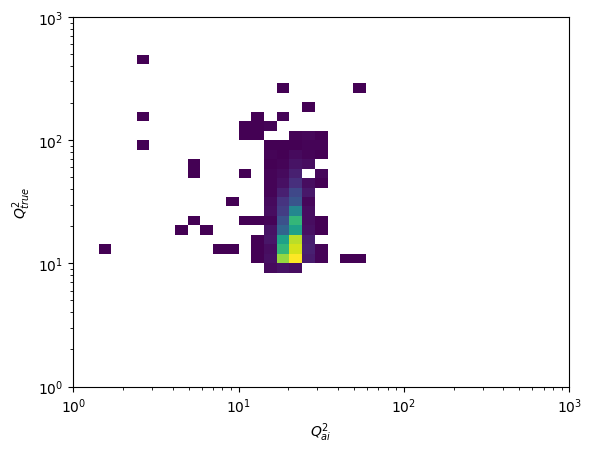

In [17]:
aiOPQ2 = []
aiTrueQ2 = []

for i in range(len(aiOPY)):
    q2 = aiOPY[i] * aiOPX[i] * s
    aiOPQ2.append(q2)
    aiTrueQ2.append(Q2true[trainingData + i])

x_bins = np.logspace(-4, 0, 30) # specify exponents of 10
Q2_bins = np.logspace(0, 3, 40) # specify exponents of 10

print(aiTrueY)

plt.hist2d(aiOPQ2, aiTrueQ2, bins = [Q2_bins, Q2_bins],cmin = 1)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$Q^2_{ai}$')
plt.ylabel('$Q^2_{true}$')